# Bayesian Parameter Estimation for α

WARNING (theano.configdefaults): Only clang++ is supported. With g++, we end up with strange g++/OSX bugs.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


Loading BokehJS ...


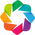

In [1]:
import numpy as np
import pandas as pd
import scipy.special
import emcee
import pymc3 as pm
import multiprocessing as mp
import corner

import bokeh.io
import bokeh.plotting
import bokeh.themes
import bokeh.document
import holoviews as hv

import pickle
import matplotlib.pyplot as plt
%matplotlib  inline
bokeh.io.output_notebook()
hv.extension('bokeh')
cpus = mp.cpu_count()

 In this notebook, I will write a Bayesian model for determination of the calibration factor $\alpha$, will test it out on some simulated data, and will then test it on some real data from Brewster et al. 2014.

## The Model 

Rather than binning the data t compute the calibration factor, I can perform a complete Bayesian regression for the parameter knowing my assumptions about the distribution of protein molecules. The crux of the model is that the intensity of one cell $I_1$ is related to the number of fluorescent protein molecules $N_1$ by a calibration $\alpha$ such that

$$
I_1 = \alpha N_1.
$$

It's important to note that the number of pretin molecules across a pair of daughter cells is conserved,

$$
N_{tot} = N_1 + N2 \Rightarrow N2 = N_{tot} - N_1.
$$

Therefore, the intensity is also conserved,

$$
I_{tot} = I_1 + I_2.
$$

Of course, there is lots of measurement error in the measurement of intensity. Using Bayes's rule, I can write down the posterior distribution I want to calculate as

$$
P(\alpha, \sigma, N_1, N_{tot}\, \vert \, I_1, I_2) \propto P(I_1, I_2 \, \vert \, \alpha, N_1, N_{tot})P(\alpha, \sigma, N_1, N_{tot}).
$$

Let's treat the likelihoods and priors with a little more rigor.

<br />
### Likelihoods 
There are really three likelihoods -- one for $I_1$, one for $I_2$, and one for $N_1$. We can make the assumption that the actual intensity measurements are gaussian distributed for each cell since there are a lot of processes that contribute to the the fluoresence of a single molecule. We can write the likelihoods for the two intensities $I_1$ and $I_2$ as

$$
P(I_1 \, \vert \, \alpha, \sigma, N_1, N_{tot}) = {1 \over \sqrt{2 \pi \sigma^2}}\exp\left[{-(I_1 - \alpha N_1)^2 \over 2 \sigma^2}\right]
$$

and

$$
P(I_2 \, \vert \, \alpha, \sigma, N_1, N_{tot}) = {1 \over \sqrt{2 \pi \sigma^2}}\exp\left[{-(I_2 - \alpha(N_{tot} - N_1))^2 \over 2\sigma^2}\right].
$$

We know that the actual protein partitioning across the two daughter cells should be Binomially distributed, allowing us to write the likelihood for $N_1$ as 

$$
P(N_1\, \vert N_{tot}, p) = {N_{tot}! \over N_1!(N_{tot} - N_1)!}p^{N_1}(1-p)^{N_{tot} - N_1}.
$$

If we make the assumption that partitioning between the two daughter cells is equal such that $p = 1/2$, the likelihood simplifies to

$$
P(N_1\, \vert N_{tot}) = {N_{tot}! \over N_1!(N_{tot} - N_1)!}\left({1 \over 2}\right)^{N_{tot}}.
$$

<br/>
### Priors

The priors are relatively simple for this case. We have separate priors for the calibration factor $\alpha$, $N_1$, and our uncertainty $\sigma$. It's fair to say that the priors for $\alpha$ and $N_1$ should be uniform, however the latter should be discrete uniform,

$$
P(\alpha) = \begin{cases}
{1 \over {\alpha_{max} - \alpha_{min}}},& \alpha_{min} \leq \alpha \leq \alpha_{max}\\
0 & \text{otherwise}
\end{cases}
$$

and 

$$
P(N_1) = \begin{cases}
{1 \over {N_{max} - N_{min}}}, & N_{min} \leq N_1 \leq N_{max}\\
0 &\text{otherwise}
\end{cases}.
$$

As $\sigma$ is a scale parameter, we can just simply use a Jeffrey's prior,

$$
P(\sigma) = {1 \over \sigma}.
$$

<br/>
### Full Posterior
Everything written so far is true for a *singele* cell division event. However, we will be looking over *many* cell division events to determine $\alpha$. We therefore need to adapt the likelihoods and priors written here to account for a the posterior for a full data set. We can just multiply the probailiteies together as they are simply independent,

$$
P(\alpha, \sigma, {N_{1,i}, N_{tot,i}}\,\vert\, {I_{1,i}, I_{2,i}}) =\\ {1 \over \sigma}\prod\limits_{i}^n{N_{tot,i}\choose{N_{1,i}}}2^{-N_{tot}}\left({1 \over \sqrt{2\pi\sigma^2}}\right)^n\exp\left[\left(-{1 \over 2\sigma^2}\right)^n\sum\limits_{i}^n \left(-(I_{1,i} - \alpha N_{1,i})^2 - (I_{2,i} - \alpha (N_{tot,i} - N_{1,i}))^2\right)\right].
$$

While complete, it's pretty gross. We can marginalize $\sigma$ to yield

$$
\begin{align}
P(\alpha, {N_{1,i}, N_{tot,i}}\,\vert\, {I_1, I_2}) &= \int\limits_0^\infty d\sigma P(\alpha, \sigma, {N_{1,i}, N_{tot,i}}\,\vert\, {I_{1,i}, I_{2,i}})\\
&=\prod\limits_i^{N_{tot,i}}{{N_{tot,i}}\choose{N_{1,i}}}2^{-N_{tot,i}}\exp\left[\sum\limits_i^n\left((I_{1,i} - \alpha N_{1,i})^2 + (I_{2,i} - \alpha(N_{tot,i} - N{1,i}))^2\right) \right]^{-n/2},
\end{align}
$$

by realizing that marginalizing $\sigma$ over a Gaussian distribution results in the Student-t distribution.

## Implementation  with MCMC

To test whether this approach is giving me the correct parameter values, I would like to try it on a sample data set where I **know** the value of $\alpha$. Back in June, I performed a realistic simulation of the dilution experiment where I introduced measurement noise into the value of $\alpha$. For that set I chose $\alpha = 150$ with a standard deviation of $10$ counts per molecule. Let's take a look at the squared intensity difference vs the sum. 

In [2]:
# Load the data. 
sim_data = pd.read_csv('../../data/other/simulated_dilution.csv')
sim_data['summed_int'] = sim_data['I_1'] + sim_data['I_2']
sim_data['squared_diff'] = (sim_data['I_1'] - sim_data['I_2'])**2

# Sample a small section of the data for computational simplicity. 
sim_data = sim_data.sample(500)
         
# Compute the theory line. 
I_tot = np.logspace(2, 7, 200)
alpha = sim_data['seeded_alpha'].unique()
theory = alpha * I_tot
    
# Set up the figure canvas
p = bokeh.plotting.figure(height=400, x_axis_label='summed intensity', 
                          y_axis_label='squared difference', 
                          x_axis_type='log', y_axis_type='log')

# Plot the points and theory.
p.scatter(x='summed_int', y='squared_diff', source=sim_data, color='slategrey', 
          alpha=0.4)
p.line(I_tot, theory, color='tomato', line_width=2,
       legend='α = {0} a.u. per molecule'.format(alpha[0]))
p.legend.location = 'top_left'
bokeh.io.show(p)

To perform the MCMC, we need to have a function to compute the log posterior. For clarity, I'll break this into three functions $-$ `log_prior` for the priors, `log_like` for the likelihood, and `log_post` which calls both. 

I need to impose actual values for the priors. As I showed up above, I'm assuming a uniform prior on both $\alpha$ and the protein copy number, meaning I have to settle on $max$ and $min$ values for each. 

For the bounds on $\alpha$, I can use some of my knowledge of the experiment. I know that I will be using a camera to make these measurements. I also know that I'll be careful not to overexpose my images. Therefore, I know that the calibration factor has to be in the range dictated by the bit depth of the camera. Assuming I use a fancy 16-bit EMCCD camera,  

$$
P(\alpha) = {1 \over \alpha_{max} - \alpha_{min}} = {1 \over (2^{16} - 1) - 0} = 65.535\times 10^{-3}.
$$


The protein copy number is a little bit more tricky as I have to figure out what the absolute maximum copy number could be for a cell. I know that the typical size of a protein is about $1\, \text{nm}^3 \approx 10^{-9}\, \text{fL}$. Approximating a standard *E. coli* cell as 1 fL bag of water, I could at absolute most fit $10^9$ proteins per cell, ignoring the fact that there are other things taking up the volume of the cell. Nevertheless, this seems like OK bound to use. My prior on $N$ is therefore,

$$
P(N_1) = {1 \over N_{max} - N_{min}} = {1 \over 10^9 - 0} = 10^{-9}.
$$

I've hard-coded these values into the `log_prior` function below. I will stick with "improper priors" are ignore them for the actual calculation of the log posterior.

In [3]:
def log_prior(p, n):
    """Priors for alpha, sigma, and protein copy numbers."""
    alpha = p[0]
    
    # Extract the protein copy numbers and convert to integer. 
    n1 = p[1:n+1].astype(int)
    ntot = p[n+1:].astype(int)
    
    # Apply the priors. 
    if (p < 0).any():
        return -np.inf
    if (n1 > n_tot).any():
        return -np.inf
    
    # Apply the hard-coded bounds.
    if alpha > 2**16 -1:
        return -np.inf
    if (n1 > 1E9).any() or (ntot > 1E9).any():
        return -np.inf
    
    # Compute the actual priors and return. 
    else:
        return np.log(1)

def log_like(p, I_1, I_2, n):
    """Computes the log likelihood."""
    
    # Unpack the parameters.
    alpha = p[0]
    n1 = p[1:n+1].astype(int)
    ntot = p[n+1:].atype(int)
    
    # Compute the log likelihood in sections so it's easier to return.   
    log_binom = -ntot.sum() * np.log(2) + scipy.special.gammaln(ntot + 1).sum() -\
                 scipy.special.gammaln(n1 + 1).sum() -\
                 scipy.special.gammaln(ntot - n1 + 1).sum()      
    log_norms = -(n/2)*np.log(((I_1 - alpha * n1)**2 +\
                (I_2 - alpha * (ntot - n1))**2).sum())
    return log_binom + log_norms

def log_post(p, I_1, I_2):
    """Combine the prior and likelihood for clarity"""
    n = len(I_1)
    n1 = p[1:n+1]
    ntot = p[n+1:]
    if (p < 0).any():
        return -np.inf
    if (n1 > ntot).any():
        return -np.inf
    else:
        return log_like(p, I_1, I_2, n)     

Now I can set up the parameters for the MCMC. 

In [4]:
# Define the various parameters of the MCMC.
num_div = len(sim_data)
n_burn = 500 # Number of burn-in steps. 
n_steps = 100 # Number of steps for each walker. 
n_dim = 2 * num_div + 1
n_walkers = 2 * n_dim + 2 

# Set the initial guesses and populate the starting positions. 
n_1 = sim_data['N_1']
n_tot = sim_data['N_1'] + sim_data['N_2']
p0 = np.empty((n_walkers, n_dim))
alpha=300
p0[:,0] = np.random.normal(alpha, scale=10, size=n_walkers)

# Ensure we start with N1 always less than Ntot
p0[:,1:num_div+1] = np.random.uniform(0, n_1*.01, size=(n_walkers, num_div))
p0[:,num_div+1:] = np.random.uniform(n_tot*.01, n_tot*.02, size=(n_walkers, num_div))

# Set up the sampler using threading. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,
                                args=(sim_data['I_1'], sim_data['I_2']), threads=cpus)

# Perform the burn-in and then sample. 
print('Beginning the burn-in...')
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
print('Finished! Now sampling....')
_ = sampler.run_mcmc(pos, n_steps, thin=100)
print('whew. That was rough. ')

emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
  params: [  2.97273246e+02   1.62540870e+01   5.99414612e-03 ...,   9.32399471e-02
   5.61368166e+01   2.68899787e+01]
  params: [  3.02369714e+02   1.20544805e+01   1.62495042e-02 ...,   1.13343788e-01
   3.39428426e+01   1.83137379e+01]emcee: Exception while calling your likelihood function:

  params: [  2.95826802e+02   2.29313830e+01   1.23444348e-02 ...,   8.43926517e-02
   5.05417930e+01   2.40977592e+01]emcee: Exception while calling your likelihood function:

emcee: Exception while calling your likelihood function:
  params: [  3.15907953e+02   5.70155112e+00   1.05790189e-02 ...,   9.46456990e-02
   4.24761478e+01   2.91445774e+01]emcee: Exception while calling your likelihood function:
  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.2

Name: I_2, Length: 500, dtype: float64)
  kwargs: {}
  params: [  2.85949424e+02   6.35180477e+00   9.70952559e-03 ...,   1.08496242e-01
   5.01119374e+01   2.72295240e+01]emcee: Exception while calling your likelihood function:


  exception:



Traceback (most recent call last):
  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)


  kwargs: {}
  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452     16643.873151
162          0.000000
977       1049.445107
1510     11176.863900
203          0.000000
2129    113143.020150
115         37.394503
1642     23995.736093
2300    203329.780815
1290      6079.511426
933       

  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)


  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452     16643.873151
162          0.000000
977       1049.445107
1510     11176.863900
203          0.000000
2129    113143.020150
115         37.394503
1642     23995.736093
2300    203329.780815
1290      6079.511426
933        984.741868
2

Traceback (most recent call last):
AttributeError: 'numpy.ndarray' object has no attribute 'atype'



  kwargs: {}
  exception:
  kwargs: {}
  exception:


  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


  exception:


Traceback (most recent call last):


  kwargs: {}


Traceback (most recent call last):
Traceback (most recent call last):


  exception:
emcee: Exception while calling your likelihood function:


  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)
  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


  exception:


  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)
  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)


  params: [  3.23445583e+02   1.11617042e+01   5.94626229e-03 ...,   1.13210597e-01
   5.11221563e+01   2.09117721e+01]

  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)
  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)
Traceback (most recent call last):


  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452     16643.873151
162          0.000000
977       1049.445107
1510     11176.863900
203          0.000000
2129    113143.020150
115         37.394503
1642     23995.736093
2300    203329.780815
1290      6079.511426
933        984.741868
2

  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
AttributeError: 'numpy.ndarray' object has no attribute 'atype'
  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)
  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)
  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)


  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)


  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)
  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)
AttributeError: 'numpy.ndarray' object has no attribute 'atype'
AttributeError: 'numpy.ndarray' object has no attribute 'atype'
AttributeError: 'numpy.ndarray' object has no attribute 'atype'
  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)


  kwargs: {}
emcee: Exception while calling your likelihood function:


AttributeError: 'numpy.ndarray' object has no attribute 'atype'


  params: [  2.93443227e+02   1.00964175e+01   1.47718588e-03 ...,   6.41043502e-02
   4.59151105e+01   2.55896919e+01]  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452     16643.873151
162          0.000000
977       1049.445107
1510     11176.863900
203          0.000000
2129    113143

AttributeError: 'numpy.ndarray' object has no attribute 'atype'


emcee: Exception while calling your likelihood function:



Traceback (most recent call last):



  kwargs: {}
emcee: Exception while calling your likelihood function:
  params: [  2.89963063e+02   1.99427355e+00   7.92075196e-03 ...,   8.32823719e-02
   5.10340778e+01   2.48995001e+01]

  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


emcee: Exception while calling your likelihood function:

  params: [  3.04130766e+02   9.93844734e+00   6.88091655e-03 ...,   1.08944523e-01
   5.95914285e+01   2.75574929e+01]  exception:
emcee: Exception while calling your likelihood function:


  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)


emcee: Exception while calling your likelihood function:


  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)


  params: [  3.04213727e+02   2.10725861e+01   1.50090722e-02 ...,   6.70195595e-02
   3.83394078e+01   2.88881478e+01]
  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452     16643.873151
162          0.000000
977       1049.445107
1510     11176.863900
203          0.000000
2129    11314

AttributeError: 'numpy.ndarray' object has no attribute 'atype'



  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452     16643.873151
162          0.000000
977       1049.445107
1510     11176.863900
203          0.000000
2129    113143.020150
115         37.394503
1642     23995.736093
2300    203329.780815
1290      6079.511426
933        984.741868


Traceback (most recent call last):


  params: [  2.96703117e+02   9.82787569e+00   3.00597830e-03 ...,   1.02686352e-01
   4.72069167e+01   2.26067651e+01]

  params: [  3.12060080e+02   8.38861621e+00   1.34399773e-02 ...,   1.11747386e-01
   5.60225597e+01   2.52796930e+01]

  kwargs: {}


  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


emcee: Exception while calling your likelihood function:
  exception:
  kwargs: {}
  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452     16643.873151
162          0.000000
977       1049.445107
1510     11176.863900
203          0.000000
2129    113143.020150
115         37.394503
1642  

  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)


  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452     16643.873151
162          0.000000
977       1049.445107
1510     11176.863900
203          0.000000
2129    113143.020150
115         37.394503
1642     23995.736093
2300    203329.780815
1290      6079.511426
933        984.741868
2

Traceback (most recent call last):



  params: [  3.06727272e+02   1.81016984e+01   8.75450418e-03 ...,   6.70188854e-02
   5.09268135e+01   2.54067802e+01]  exception:


  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)


  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452     16643.873151
162          0.000000
977       1049.445107
1510     11176.863900
203          0.000000
2129    113143.020150
115         37.394503
1642     23995.736093
2300    203329.780815
1290      6079.511426
933        984.741868
2

Traceback (most recent call last):
  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


  kwargs: {}


AttributeError: 'numpy.ndarray' object has no attribute 'atype'



  exception:
  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452     16643.873151
162          0.000000
977       1049.445107
1510     11176.863900
203          0.000000
2129    113143.020150
115         37.394503
1642     23995.736093
2300    203329.780815
1290      6079.511426
933      

  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)


  kwargs: {}


Traceback (most recent call last):



  kwargs: {}


  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)


  kwargs: {}


  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)


  exception:


  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


emcee: Exception while calling your likelihood function:
  exception:


  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)
Traceback (most recent call last):


  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452     16643.873151
162          0.000000
977       1049.445107
1510     11176.863900
203          0.000000
2129    113143.020150
115         37.394503
1642     23995.736093
2300    203329.780815
1290      6079.511426
933        984.741868
2

AttributeError: 'numpy.ndarray' object has no attribute 'atype'


  exception:


AttributeError: 'numpy.ndarray' object has no attribute 'atype'
Traceback (most recent call last):
  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)


  params: [  2.99262877e+02   1.14183990e+01   7.04075870e-03 ...,   9.52128442e-02
   4.81667996e+01   2.02260442e+01]

  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):


  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)
  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)



emcee: Exception while calling your likelihood function:


  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)
AttributeError: 'numpy.ndarray' object has no attribute 'atype'


  kwargs: {}
  exception:


  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)


emcee: Exception while calling your likelihood function:


  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)
  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)


  params: [  2.98319117e+02   1.08729089e+00   3.56232772e-03 ...,   7.79184393e-02
   6.06908918e+01   3.40139340e+01]

  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)
Traceback (most recent call last):


emcee: Exception while calling your likelihood function:
  params: [  3.02549740e+02   2.04754731e+01   4.21377894e-03 ...,   1.14929351e-01
   6.02480862e+01   1.83326026e+01]

AttributeError: 'numpy.ndarray' object has no attribute 'atype'
AttributeError: 'numpy.ndarray' object has no attribute 'atype'


  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)
  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)



  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452     16643.873151
162          0.000000
977       1049.445107
1510     11176.863900
203          0.000000
2129    113143.020150
115         37.394503
1642     23995.736093
2300    203329.780815
1290      6079.511426
933        984.741868


AttributeError: 'numpy.ndarray' object has no attribute 'atype'


  params: [  3.24037034e+02   1.86001111e+01   1.29419118e-02 ...,   8.03287669e-02
   5.86577073e+01   2.10277390e+01]

  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)


emcee: Exception while calling your likelihood function:

  params: [  3.24414399e+02   5.52049942e+00   9.20792947e-03 ...,   1.16535447e-01
   4.98092355e+01   2.57310927e+01]emcee: Exception while calling your likelihood function:

  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452    

  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)


emcee: Exception while calling your likelihood function:


AttributeError: 'numpy.ndarray' object has no attribute 'atype'


  params: [  2.91856727e+02   1.78160627e+01   1.40891847e-02 ...,   7.62128646e-02
   4.08360082e+01   2.17335920e+01]
  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452     16643.873151
162          0.000000
977       1049.445107
1510     11176.863900
203          0.000000
2129    11314

Traceback (most recent call last):
Traceback (most recent call last):


  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


  params: [  3.04129591e+02   1.39316010e+01   1.68068008e-02 ...,   8.27083036e-02
   4.31324752e+01   1.92978525e+01]
  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452     16643.873151
162          0.000000
977       1049.445107
1510     11176.863900
203          0.000000
2129    11314

  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


  exception:
  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452     16643.873151
162          0.000000
977       1049.445107
1510     11176.863900
203          0.000000
2129    113143.020150
115         37.394503
1642     23995.736093
2300    203329.780815
1290      6079.511426
933       

  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)
  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)
  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)


  params: [  3.07360229e+02   1.40396134e+01   1.31693540e-02 ...,   1.02982684e-01
   4.11902226e+01   3.41674318e+01]


Traceback (most recent call last):



  kwargs: {}


  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)


  kwargs: {}


AttributeError: 'numpy.ndarray' object has no attribute 'atype'


  exception:
  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452     16643.873151
162          0.000000
977       1049.445107
1510     11176.863900
203          0.000000
2129    113143.020150
115         37.394503
1642     23995.736093
2300    203329.780815
1290      6079.511426
933       

  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


  exception:


AttributeError: 'numpy.ndarray' object has no attribute 'atype'
  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)
Traceback (most recent call last):



  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452     16643.873151
162          0.000000
977       1049.445107
1510     11176.863900
203          0.000000
2129    113143.020150
115         37.394503
1642     23995.736093
2300    203329.780815
1290      6079.511426
933        984.741868


Traceback (most recent call last):


  kwargs: {}


  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)
  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)


  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452     16643.873151
162          0.000000
977       1049.445107
1510     11176.863900
203          0.000000
2129    113143.020150
115         37.394503
1642     23995.736093
2300    203329.780815
1290      6079.511426
933        984.741868
2

AttributeError: 'numpy.ndarray' object has no attribute 'atype'


  exception:
  kwargs: {}


  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)
  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)


Traceback (most recent call last):
AttributeError: 'numpy.ndarray' object has no attribute 'atype'


  kwargs: {}


  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)


  exception:


Traceback (most recent call last):
  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


  exception:


AttributeError: 'numpy.ndarray' object has no attribute 'atype'
  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)
  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)
  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):


emcee: Exception while calling your likelihood function:


  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)
  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)
AttributeError: 'numpy.ndarray' object has no attribute 'atype'
  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)


emcee: Exception while calling your likelihood function:


AttributeError: 'numpy.ndarray' object has no attribute 'atype'


emcee: Exception while calling your likelihood function:
  params: [  3.05571082e+02   1.79327147e+01   5.14780021e-03 ...,   1.07051149e-01
   3.46132027e+01   2.82923671e+01]

  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)


  params: [  2.92081702e+02   2.37794140e+01   4.52375950e-03 ...,   6.13023204e-02
   5.07166209e+01   1.92660598e+01]
  params: [  2.83640214e+02   6.05799373e+00   1.30284817e-02 ...,   8.49571108e-02
   6.41887179e+01   2.99858740e+01]

AttributeError: 'numpy.ndarray' object has no attribute 'atype'




emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
  params: [  3.02864447e+02   1.86747926e+00   1.21186703e-02 ...,   8.55907768e-02
   3.67373774e+01   2.25708858e+01]emcee: Exception while calling your likelihood function:
emcee: Exception while calling your likelihood function:
Beginning the burn-in...

  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624      

Name: I_2, Length: 500, dtype: float64)  params: [  3.00425940e+02   5.96607306e+00   1.42263874e-02 ...,   1.12445439e-01
   6.33165476e+01   1.82873043e+01]
  kwargs: {}


  kwargs: {}
  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452     16643.873151
162          0.000000
977       10

Traceback (most recent call last):


  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


  kwargs: {}


  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)


  exception:

  exception:
  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452     16643.873151
162          0.000000
977       1049.445107
1510     11176.863900
203          0.000000
2129    113143.020150
115         37.394503
1642     23995.736093
2300    203329.780815
1290      6079.511

  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)
Traceback (most recent call last):


  kwargs: {}
  kwargs: {}


Traceback (most recent call last):



  kwargs: {}
  exception:


AttributeError: 'numpy.ndarray' object has no attribute 'atype'
  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)


  exception:


Traceback (most recent call last):


  kwargs: {}


  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
Traceback (most recent call last):
  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)


  exception:
  exception:


  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)
  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)
Traceback (most recent call last):
Traceback (most recent call last):
  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)
  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)
  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)
  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)
  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like


  args: (2267    141240.974955
336         91.040892
1188      3414.544043
1105      2090.806218
1645     22323.214915
517        142.772302
1041      2576.425374
2004     68787.285600
1994     79713.897513
1424      9227.864968
2230    170787.566017
1784     31971.682854
1313      5286.438713
440        110.321424
211         43.912735
1226      4179.038610
1517     10420.346973
985       1013.090911
1543     25014.059054
4           33.747998
2250    190152.797410
167         81.281774
113          0.000000
1168      3328.258159
2288    338122.365571
624        230.388710
475        162.435581
1063      1907.836595
1564     25392.580571
538        110.796770
            ...      
1123      2412.252838
449         91.407624
2366    167503.672372
1452     16643.873151
162          0.000000
977       1049.445107
1510     11176.863900
203          0.000000
2129    113143.020150
115         37.394503
1642     23995.736093
2300    203329.780815
1290      6079.511426
933        984.741868
2

  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)
AttributeError: 'numpy.ndarray' object has no attribute 'atype'
  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)


AttributeError: 'numpy.ndarray' object has no attribute 'atype'
AttributeError: 'numpy.ndarray' object has no attribute 'atype'


  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/gchure/anaconda/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-3-57b8645b8adf>", line 48, in log_post
    return log_like(p, I_1, I_2, n)
  File "<ipython-input-3-57b8645b8adf>", line 31, in log_like
    ntot = p[n+1:].atype(int)
AttributeError: 'numpy.ndarray' object has no attribute 'atype'


AttributeError: 'numpy.ndarray' object has no attribute 'atype'

In [127]:
# For safety, save the flatchain as a pickle
output = open('../../data/other/dilution_simulation_flatchain_delbruck.pkl', 'wb')
pickle.dump(sampler.flatchain, output)
pickle.dump(sampler.flatlnprobability, output)
output.close() # close it to make sure it's all been written

Since I have a shitload of parameters, I can't show the distribution for everything. However, I can plot the marginalized distribution for the posterior on $\alpha$. Rather than computing the mean and standard deviation, I'll opt to compute the mode and the credible region showing 95% of the sample density. 

In [128]:
# #################
def hpd(trace, mass_frac):
    """
    Returns highest probability density region given by
    a set of samples.
    Parameters
    ----------
    trace : array
        1D array of MCMC samples for a single variable
    mass_frac : float with 0 < mass_frac <= 1
        The fraction of the probability to be included in
        the HPD.  For hreple, `massfrac` = 0.95 gives a
        95% HPD.

    Returns
    -------
    output : array, shape (2,)
        The bounds of the HPD

    Notes
    -----
    We thank Justin Bois (BBE, Caltech) for developing this function.
    http://bebi103.caltech.edu/2015/tutorials/l06_credible_regions.html
    """
    # Get sorted list
    d = np.sort(np.copy(trace))

    # Number of total samples taken
    n = len(trace)

    # Get number of samples that should be included in HPD
    n_samples = np.floor(mass_frac * n).astype(int)

    # Get width (in units of data) of all intervals with n_samples samples
    int_width = d[n_samples:] - d[:n - n_samples]

    # Pick out minimal interval
    min_int = np.argmin(int_width)

    # Return interval
    return np.array([d[min_int], d[min_int + n_samples]])


In [129]:
# Compute the histogram for the posterior distribution of alpha.
hist, edges = np.histogram(sampler.flatchain[:,0], bins=75)

# Compute the mode and HPD from the flatlnprob. 
ind = np.argmax(sampler.flatlnprobability)
mode = sampler.flatchain[ind,0]
cred_region = hpd(sampler.flatchain[:,0], 0.95)

# # Set up the figure
p = bokeh.plotting.figure(height=500, 
                          x_axis_label='calibration factor (a.u. per molecule)',
                          y_axis_label='posterior distribution',
                         tools="reset,hover,wheel_zoom,pan")
p.quad(top=hist, bottom=0, left=edges[1:], right=edges[:-1],
        fill_color='slategray', alpha=0.7, line_color='slategray')

p.ray(x=[mode], y=[0], length=0, angle=np.deg2rad(90), line_width=2, color='tomato',
     legend='mode')
p.ray(x=[cred_region[0]], y=[0], length=0, angle=np.deg2rad(90), line_width=2, color='dodgerblue',
     legend='credible region')
p.ray(x=[cred_region[1]], y=[0], length=0, angle=np.deg2rad(90), line_width=2, color='dodgerblue')
bokeh.io.show(p)

# Print the mode and HPD. 
print('The best estimate for calibration factor is {0:1.0f} +{2:1.0f} -{1:1.0f} a.u. per molecule'.format(
mode,  mode - cred_region[0], cred_region[1] - mode))

The best estimate for calibration factor is 295 +24 -14 a.u. per molecule


That seems pretty great! I get a mode right in the range of the expected $\alpha$ and the credible regions make a lot of sense.  

In [130]:
df = pd.DataFrame([sampler.flatchain[:,0], sampler.flatchain[:,1]]).T
df.columns=['alpha', 'sigma']

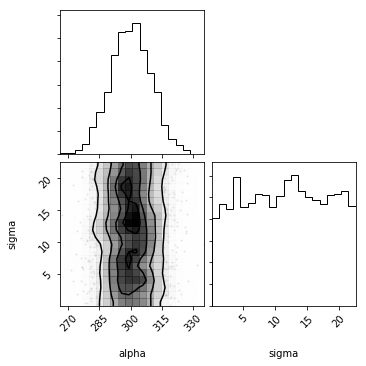

In [131]:
corner.corner(df, smooth=True)

In [133]:
np.unique(sampler.flatlnprobability)

array([-inf])

In [124]:
np.unique(np.exp(sampler.flatlnprobability))

array([ 0.])

## Using PyMC3

In [ ]:
model = pm.Model()
size = len(sim_data)
bit_depth = 2**16 - 1
with model:
    # Define the priors 
    alpha = pm.Uniform('alpha', lower=0, upper=bit_depth, testval=50)
    I_tot = (sim_data['I_1'] + sim_data['I_2']).values
    N_tot = pm.Uniform('n_tot', lower=0, upper=1E5, testval=400)
    n = pm.Uniform('n', lower=0, upper=N_tot, testval=200)
    bino_like = pm.Binomial.dist(N_tot, 0.5, shape=size)
    student_1 = pm.StudentT.dist(1, mu=alpha * n, shape=size)
    student_2 = pm.StudentT.dist(1, mu=alpha * (N_tot - n), shape=size)
    
    f = pm.Dirichlet('f', a=np.ones(3))
    obs = sim_data.loc[:, ['I_1', 'I_2', '']].values
#     obs = np.meshgrid([sim_data['I_1'].values, sim_data['I_2'].values, n])
    mix = pm.Mixture('likelihood', f, [student_1, student_2, bino_like], observed=obs)
                                                                
    

    trace =pm.sample(500, tune=100, njobs=None)

/Users/gchure/anaconda/lib/python3.6/site-packages/theano/tensor/basic.py:2146: UserWarning: theano.tensor.round() changed its default from `half_away_from_zero` to `half_to_even` to have the same default as NumPy. Use the Theano flag `warn.round=False` to disable this warning.
  "theano.tensor.round() changed its default from"
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...

  2%|▏         | 4545/200000 [22:46<16:34:31,  3.28it/s]

In [27]:
sim_data

,Unnamed: 0,seeded_alpha,simulated_alpha,alpha_std,N_1,N_2,I_1,I_2,summed_int,squared_diff
2267,2267,50.0,56.723283,10.0,2490.0,2650.0,141240.974955,150316.700253,291557.675208,8.236879e+07
336,336,50.0,45.520446,10.0,2.0,2.0,91.040892,91.040892,182.081785,0.000000e+00
1188,1188,50.0,43.222076,10.0,79.0,77.0,3414.544043,3328.099890,6742.643934,7.472592e+03
1105,1105,50.0,50.995274,10.0,41.0,40.0,2090.806218,2039.810944,4130.617161,2.600518e+03
1645,1645,50.0,59.056124,10.0,378.0,374.0,22323.214915,22086.990419,44410.205334,5.580201e+04
517,517,50.0,47.590767,10.0,3.0,4.0,142.772302,190.363069,333.135371,2.264881e+03
1041,1041,50.0,40.895641,10.0,63.0,50.0,2576.425374,2044.782043,4621.207416,2.826446e+05
2004,2004,50.0,43.453750,10.0,1583.0,1508.0,68787.285600,65528.254380,134315.539980,1.062128e+07
1994,1994,50.0,60.025525,10.0,1328.0,1377.0,79713.897513,82655.148250,162369.045763,8.650956e+06
1424,1424,50.0,59.921201,10.0,154.0,159.0,9227.864968,9527.470973,18755.335941,8.976376e+04


In [112]:
obs

array([[           nan,  8123.4072787 ,  7146.54184645],
       [           nan,  2066.74690226,  2000.07764734],
       [           nan,   152.13806795,   152.13806795],
       ..., 
       [           nan,   703.62793004,   629.56183214],
       [           nan,  2552.81271498,  1661.35430658],
       [           nan,    50.98030235,     0.        ]])

In [13]:
I_tot.shape

(500,)

In [85]:
model.basic_RVs

[alpha_interval_]

In [80]:
alpha

alpha

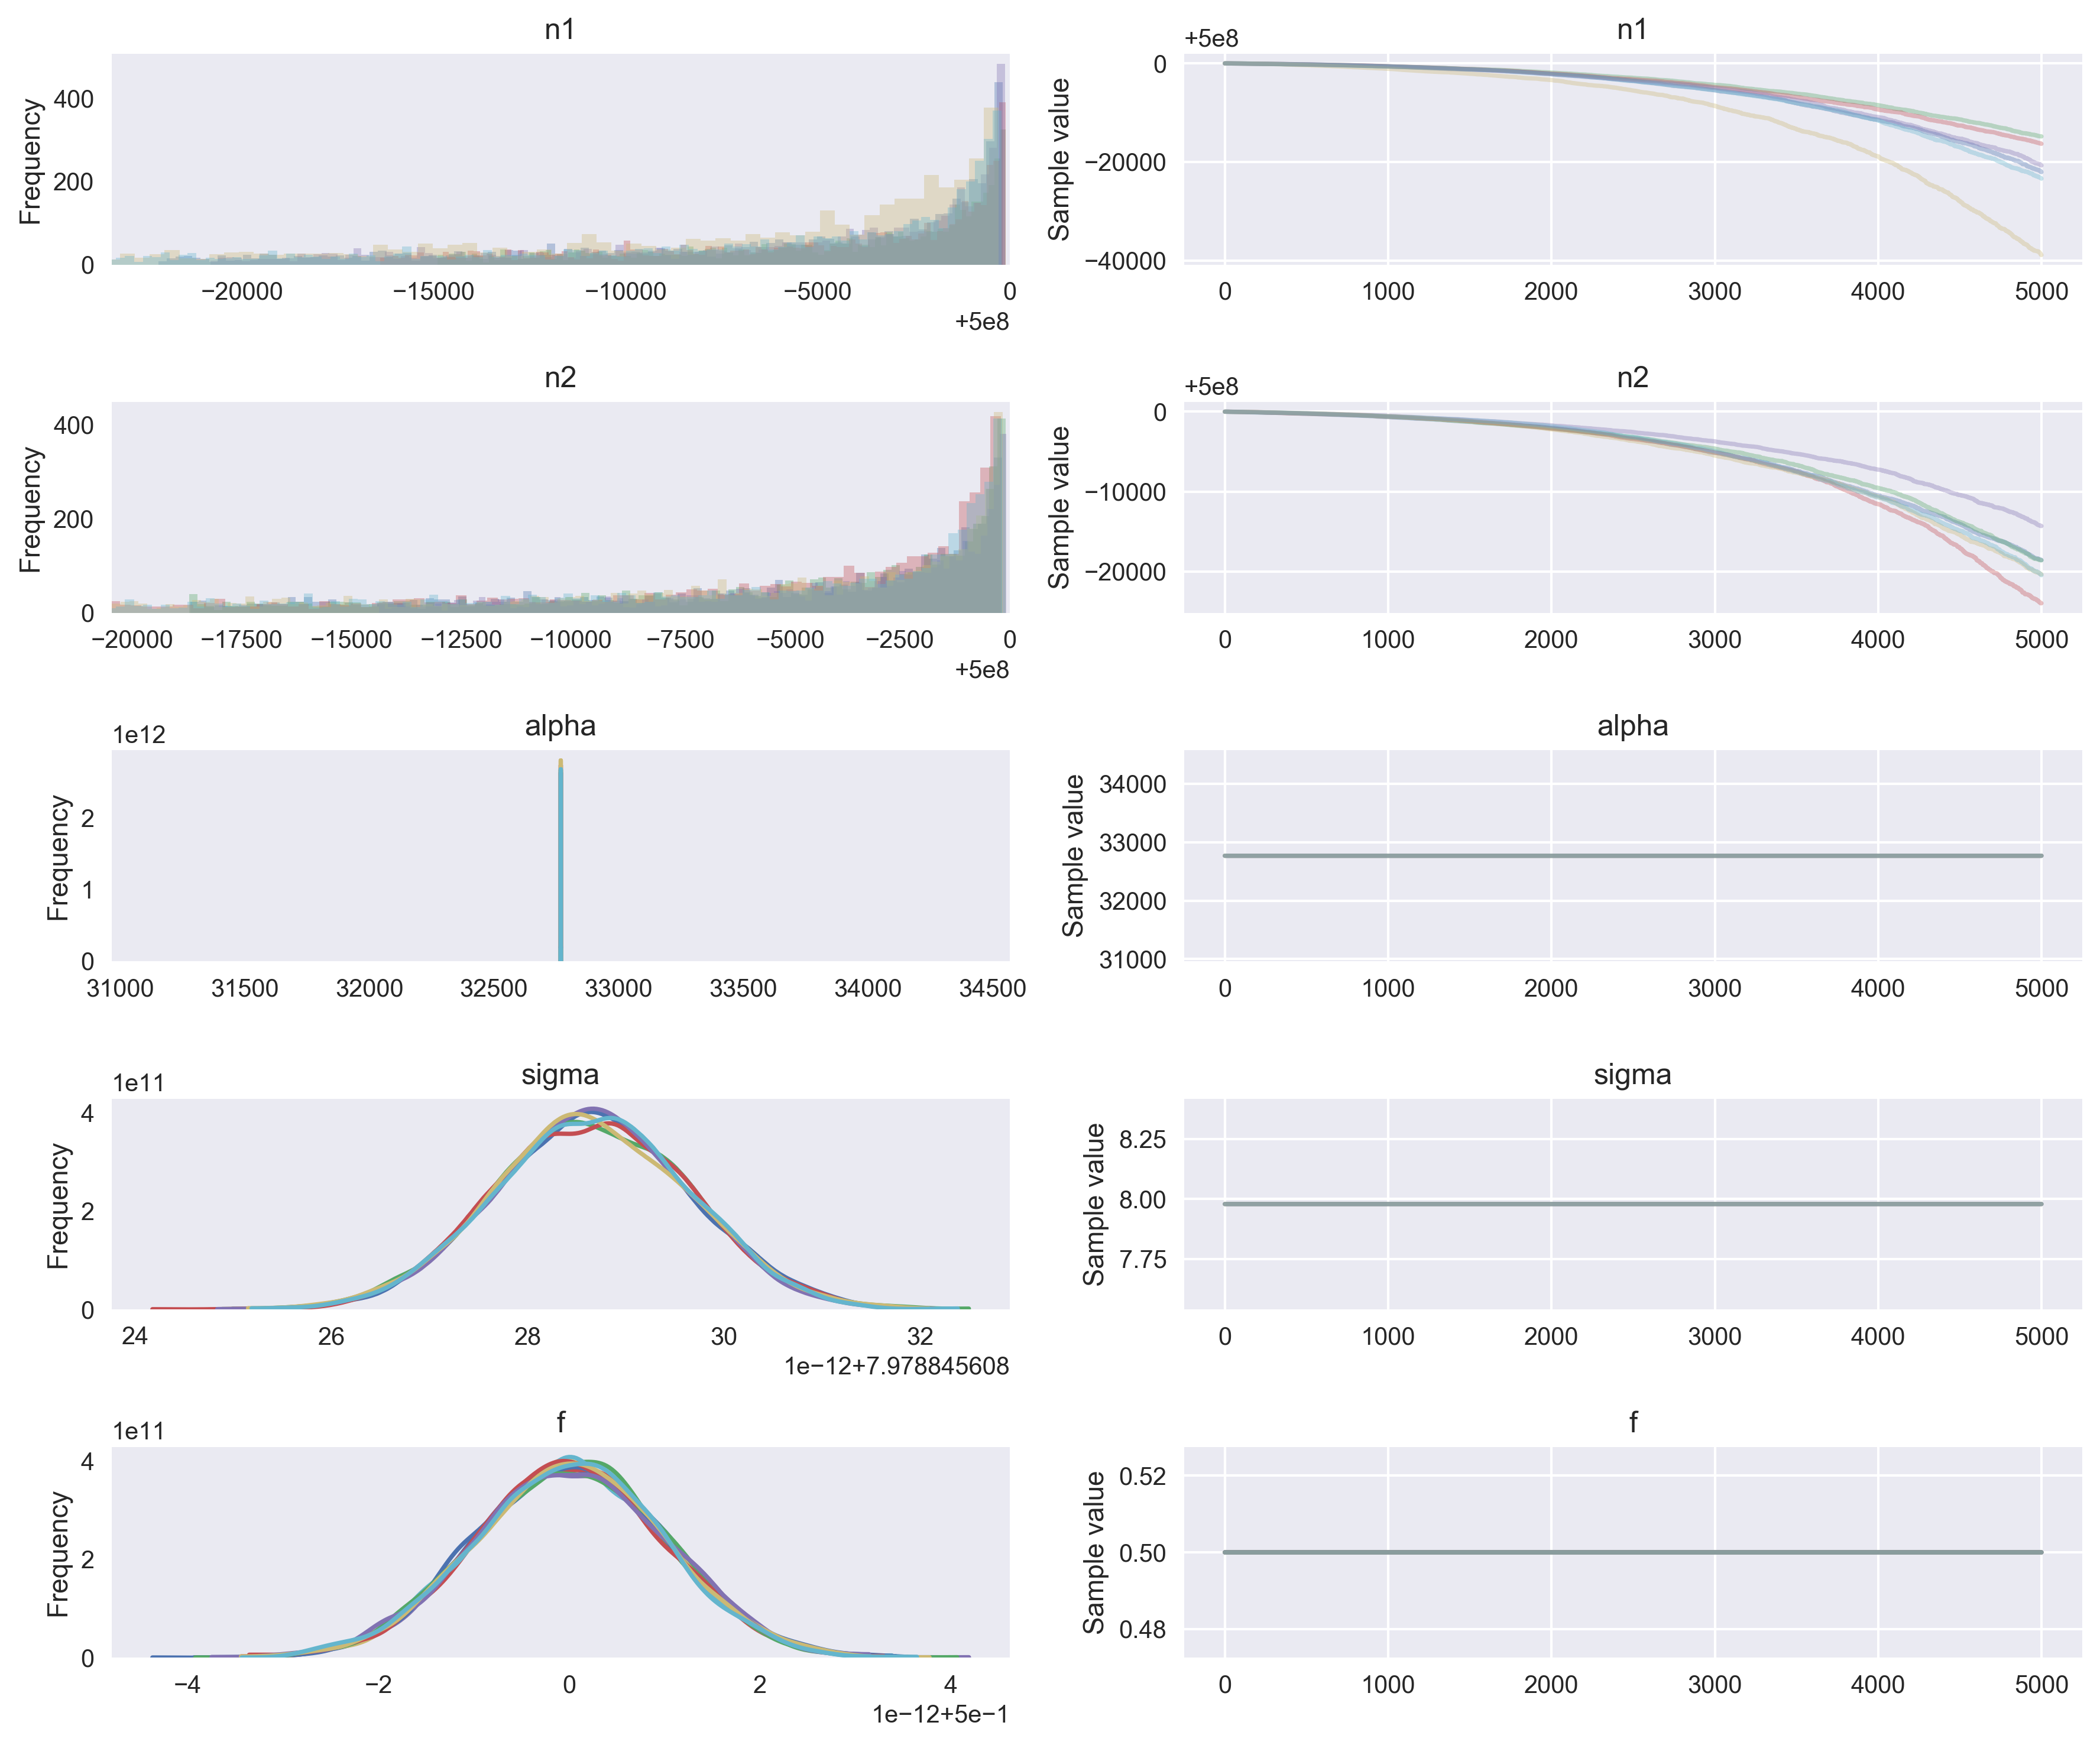

In [74]:
_ = pm.traceplot(trace)

In [72]:
df = pm.trace_to_dataframe(trace)
df.head()


,n1,n2,alpha,sigma,f__0,f__1
0,500000000,500000000,32767.5,7.978846,0.5,0.5
1,500000000,500000000,32767.5,7.978846,0.5,0.5
2,499999999,499999999,32767.5,7.978846,0.5,0.5
3,499999998,499999999,32767.5,7.978846,0.5,0.5
4,499999998,499999999,32767.5,7.978846,0.5,0.5


In [47]:
sim_data.size()

TypeError: 'numpy.int64' object is not callable

In [ ]:
pm.Dis

In [52]:
_ = pm.Normal.dist(10)
_.logp(np.array([4, 2, 3, 4])).eval()


array([-18.91893853, -32.91893853, -25.41893853, -18.91893853])

In [4]:
sim_data

,Unnamed: 0,seeded_alpha,simulated_alpha,alpha_std,N_1,N_2,I_1,I_2,summed_int,squared_diff
1885,1885,50.0,39.577650,10.0,831.0,-828.0,32889.027080,32770.294130,65659.321210,1.409751e+04
1025,1025,50.0,31.080541,10.0,56.0,-49.0,1740.510320,1522.946530,3263.456849,4.733400e+04
2096,2096,50.0,51.075220,10.0,1767.0,-1886.0,90249.914109,96327.865314,186577.779423,3.694149e+07
1823,1823,50.0,54.372602,10.0,648.0,-629.0,35233.446271,34200.366828,69433.813098,1.067253e+06
495,495,50.0,63.212527,10.0,1.0,-4.0,63.212527,252.850108,316.062635,3.596241e+04
1935,1935,50.0,65.141567,10.0,851.0,-841.0,55435.473595,54784.057924,110219.531519,4.243424e+05
17,17,50.0,60.632538,10.0,0.0,-1.0,0.000000,60.632538,60.632538,3.676305e+03
927,927,50.0,40.378949,10.0,22.0,-22.0,888.336881,888.336881,1776.673762,0.000000e+00
2023,2023,50.0,67.579740,10.0,981.0,-1004.0,66295.724917,67850.058937,134145.783854,2.415954e+06
1364,1364,50.0,46.906921,10.0,226.0,-227.0,10600.964162,10647.871083,21248.835246,2.200259e+03
